# TMA4320 Technical Physics Project
### Oliver Ruden, Åsmund Mjøs & Astrid Mysterud

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import timeit
import time

In this project we are to calculate something :)

# 1a)
We start by analyzing a simple test case, where the position of the particles is determined by the ODE
\begin{align*}
    \dot{\mathbf{x}}&=\mathbf{f}(\mathbf{x},t)\\
    &=[v_x(\mathbf{x},t), v_y(\mathbf{x},t)]
\end{align*}
where the velocity components and the parameters are as described in equation $(4)$ in the project description. We will be looking at the region $x\in[0,2]$ and $y\in[0,1]$, and the time interval $t\in[0,50]$. The following code block initializes the parameters $A$, $\epsilon$ and $\omega$, and defines the functions as in equation $(4)$.

In [3]:
A = 0.1
epsilon = 0.25
omega = 1

a = lambda t: epsilon * np.sin(omega * t)
b = lambda t: 1 - 2 * epsilon * np.sin(omega * t)

f = lambda x, t : a(t) * x ** 2 + b(t) * x
dfdx = lambda x, t : 2 * a(t) * x + b(t)

v_x = lambda x, y, t: -np.pi * A * np.sin(np.pi * f(x, t)) * np.cos(np.pi * y)
v_y = lambda x, y, t: np.pi * A * np.cos(np.pi * f(x, t)) * np.sin(np.pi * y) * dfdx(x, t)

val_0 = np.array([1.05, 0.5])

func = lambda x,y, t: np.column_stack((v_x(x,y, t), v_y(x, y, t)))

Vi skal bruke heuns

In [4]:
"""
2 dimensjonal vektorfunksjon
"""

def heun(func, start_val, t_start, t_stop, h):

    t_array = np.arange(t_start, t_stop, h)
    if np.shape(start_val) == (2,):
        val_array = np.zeros((np.shape(t_array)+(1,)+np.shape(start_val)))
    else:
        val_array = np.zeros((np.shape(t_array)+np.shape(start_val)))
    val_array[0] = start_val
    for i in range(len(t_array)-1):
        k_1 = func(val_array[i,:,0],val_array[i,:,1],t_array[i])
        k_2 = func(val_array[i,:,0]+h*k_1[:,0],val_array[i,:,1]+h*k_1[:,1], t_array[i+1])
        val_array[i+1]=val_array[i]+h/2*(k_1+k_2)
    
    return [t_array, val_array]

her tester vi heuns som spurt i 1a

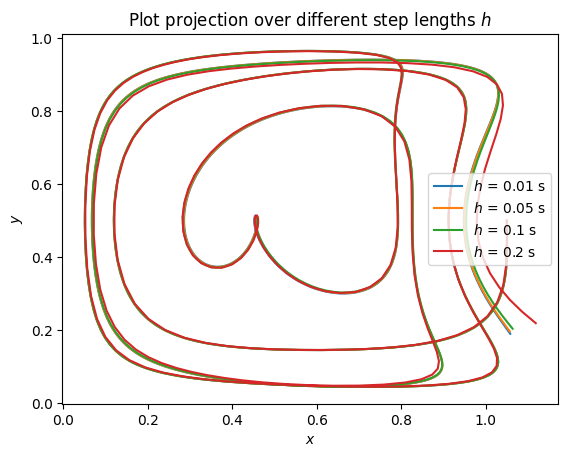

In [75]:
for h in [0.01, 0.05, 0.1, 0.2]:
    [t_array, val_array] = heun(func, val_0, 0, 50, h)
    plt.plot(val_array[:,:,0], val_array[:,:,1], label = rf'$h$ = {h} s')

plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Plot projection over different step lengths $h$ ')
plt.show()

# 1b
tekst til 1b

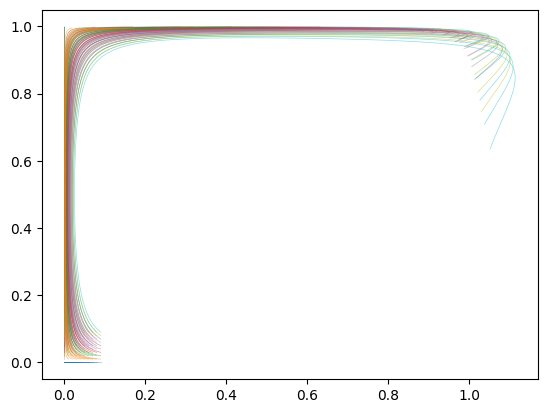

In [25]:
# code for 1b
N_p = 100
N_ps = int(np.sqrt(N_p))
xmax = 0.1
ymax = 0.1
t_start = 0
t_end = 10
iterations = 1000
h = (t_end-t_start)/iterations
grid = np.array([(i/N_ps*xmax,j/N_ps*ymax)for i in range(N_ps) for j in range(N_ps)])

t,x = heun(func, grid, t_start, t_end, h)

plt.plot(x[:,:,0], x[:,:,1], alpha=0.5, lw=0.5)
plt.show()

# 1c
tekst til 1c

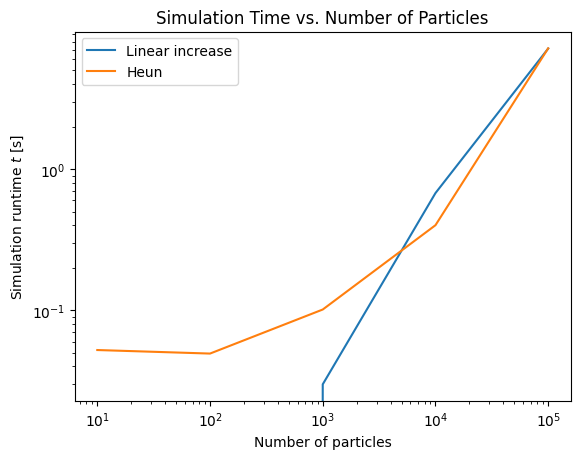

In [7]:
N_p = np.array([10, 10**2, 10**3, 10**4, 10**5])
times = []
for N_iter in N_p:
    start_time = time.time()
    heun(func, [val_0]*N_iter, 0, 50, 0.1)
    end_time = time.time()
    times.append(end_time-start_time)

def linear_func(x):
    [a, b] = np.polyfit(N_p, times, 1)
    return a*x+b

plt.plot(N_p, linear_func(N_p), label = "Linear increase")
plt.loglog(N_p, times, label = "Heun")
plt.xlabel("Number of particles")
plt.ylabel(r'Simulation runtime $t$ [s]')
plt.title(r'Simulation Time vs. Number of Particles')
plt.legend()
plt.show()


# 2a

In [8]:
f_w = 0.03
h = 3600 # seconds
N_p = 30 # suitable, så ikke lang tid

# random initial conditions
x_array = np.random.normal(790000, 10000, N_p)
y_array = np.random.normal(490000, 10000, N_p)

# 2b

In [9]:
# code for 2b

# 3a

In [10]:
N_p = 10
t_0 = 0
t_end = 3 * 24 * 3600
h = 3600

coords = np.random.normal(250000, 10000, (N_p, 2))
coords[:,1] += 210000

# plot of distribution of stranded particles

# plot of percentage of all particles that are stranded as a function of time

# 3b

In [2]:
# different windage factors
for f_w in [0, 0.05, 0.1, 0.15]:
    print(f_w)

0
0.05
0.1
0.15


# conclusion